In [1]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import Pool

In [2]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=columns)
df = df.sample(frac=0.1, random_state=42)  # Sampling for quicker processing

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [WordNetLemmatizer().lemmatize(token) for token in tokens if token not in stopwords.words('english')]
    return ' '.join(tokens)

def preprocess_text_parallel(text_data):
    with Pool(processes=4) as pool:
        results = pool.map(preprocess_text, text_data)
    return results

df['cleaned_text'] = preprocess_text_parallel(df['text'])

In [4]:
X = df['cleaned_text']
y = df['target'].replace({0: 0, 4: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

parameters_lr = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1, 10],
}

grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, cv=5, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
print(f'Best Score (LR): {grid_search_lr.best_score_}')
print(f'Best Parameters (LR): {grid_search_lr.best_params_}')

Best Score (LR): 0.7718984375000001
Best Parameters (LR): {'classifier__C': 1, 'tfidf__ngram_range': (1, 2)}


In [6]:
predictions_lr = grid_search_lr.best_estimator_.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, predictions_lr, target_names=['Negative', 'Positive']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.78      0.78     15878
    Positive       0.78      0.78      0.78     16122

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000



In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [8]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_seq_length = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [10]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_shape=(max_seq_length,)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test_cat), verbose=2)

Epoch 1/5


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2000/2000 - 70s - 35ms/step - accuracy: 0.7478 - loss: 0.5095 - val_accuracy: 0.7714 - val_loss: 0.4745
Epoch 2/5
2000/2000 - 69s - 34ms/step - accuracy: 0.7759 - loss: 0.4669 - val_accuracy: 0.7731 - val_loss: 0.4712
Epoch 3/5
2000/2000 - 68s - 34ms/step - accuracy: 0.7870 - loss: 0.4477 - val_accuracy: 0.7721 - val_loss: 0.4710
Epoch 4/5
2000/2000 - 68s - 34ms/step - accuracy: 0.7959 - loss: 0.4319 - val_accuracy: 0.7724 - val_loss: 0.4771
Epoch 5/5
2000/2000 - 68s - 34ms/step - accuracy: 0.8033 - loss: 0.4180 - val_accuracy: 0.7677 - val_loss: 0.4829


In [11]:
# Evaluate the model on the test set
evaluation = model.evaluate(X_test_pad, y_test_cat, batch_size=64, verbose=2)

print(f'Test Loss: {evaluation[0]:.4f}')
print(f'Test Accuracy: {evaluation[1]:.4f}')

500/500 - 5s - 11ms/step - accuracy: 0.7677 - loss: 0.4829
Test Loss: 0.4829
Test Accuracy: 0.7677


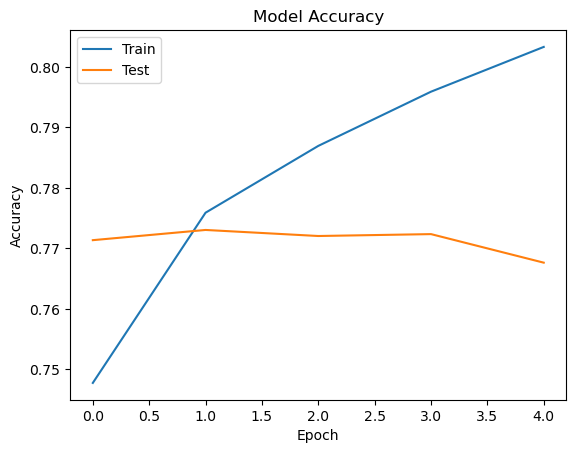

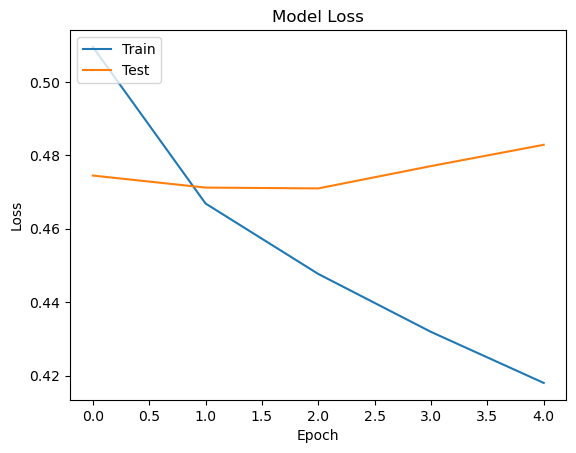

In [12]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# Identify misclassifications
misclassified_idxs = np.where(predictions_lr != y_test)[0]
sample_idxs = np.random.choice(misclassified_idxs, 10, replace=False)

# Display some misclassified tweets
for idx in sample_idxs:
    print(X_test.iloc[idx])
    print(f'Actual Label: {y_test.iloc[idx]}, Predicted: {predictions_lr[idx]}')
    print('---')

know im rural america passed starbucks two tractor parked outside seriously
Actual Label: 1, Predicted: 0
---
back killing loved loved loved new star trek complete homage roddenberry warmed trekker heart lt
Actual Label: 0, Predicted: 1
---
listening diddy puffy bad boy life hold remix dude talking whole track grrrr rapper
Actual Label: 0, Predicted: 1
---
see huuuge mass cloud coming block sun
Actual Label: 0, Predicted: 1
---
going bed nothing maybe happiness bring really good dream
Actual Label: 0, Predicted: 1
---
say sleepless friday night sleepfull saturday
Actual Label: 1, Predicted: 0
---
got back inside playing trampoline im tired
Actual Label: 1, Predicted: 0
---
name floating around head lily allen song throughout night grrr
Actual Label: 0, Predicted: 1
---
quitting hard one week
Actual Label: 1, Predicted: 0
---
aww lot im bit wasted
Actual Label: 1, Predicted: 0
---


In [15]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=columns)
sampled_df = df.sample(frac=0.1, random_state=42)  # Sampling for quicker processing

In [17]:
import pandas as pd

# Assuming df is your main dataframe after loading the data
# And sampled_df is the dataframe after taking a 10% sample

# Count the number of tweets per sentiment before sampling
before_sampling = df['target'].value_counts()

# Count the number of tweets per sentiment after sampling
after_sampling = sampled_df['target'].value_counts()

# Create a dataframe to display the counts in a table
composition_table = pd.DataFrame({'Before Sampling': before_sampling, 'After Sampling': after_sampling})

composition_table

,Before Sampling,After Sampling
target,,
0,800000,79812
4,800000,80188


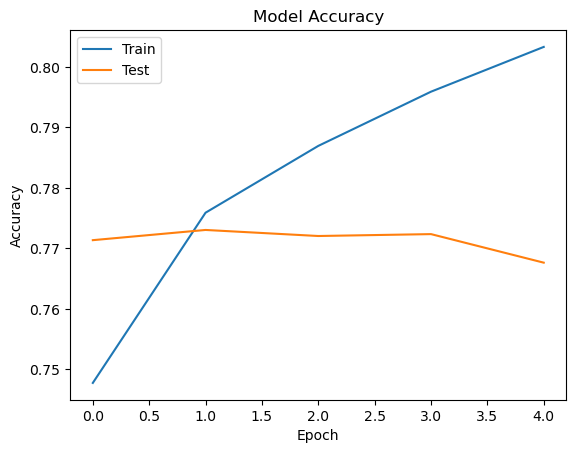

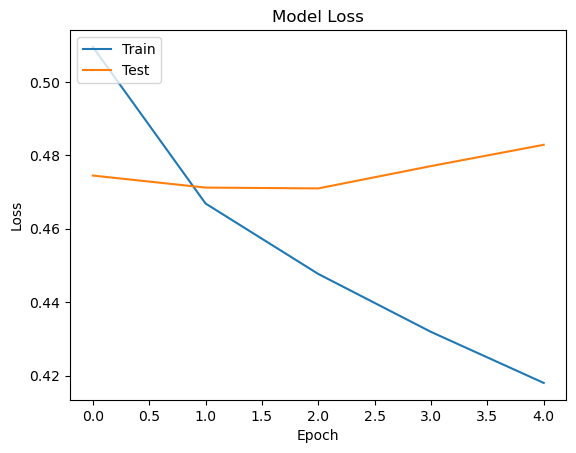

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
# Generate predictions for the test set
lstm_predictions_categorical = model.predict(X_test_pad)

# Convert these predictions from categorical (one-hot encoded) to the label encoding (0 or 1)
lstm_predictions = np.argmax(lstm_predictions_categorical, axis=1)

# Now you can generate a classification report
report_lstm = classification_report(y_test, lstm_predictions, output_dict=True)

# And then proceed with creating the table for the LSTM performance metrics
df_report_lstm = pd.DataFrame(report_lstm).transpose()
print("\nLSTM Performance Metrics:")
print(df_report_lstm)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step

LSTM Performance Metrics:
              precision    recall  f1-score       support
0              0.761248  0.774720  0.767925  15878.000000
1              0.774194  0.760700  0.767387  16122.000000
accuracy       0.767656  0.767656  0.767656      0.767656
macro avg      0.767721  0.767710  0.767656  32000.000000
weighted avg   0.767770  0.767656  0.767654  32000.000000


In [23]:
from sklearn.metrics import classification_report

# Generate classification reports
report_lr = classification_report(y_test, predictions_lr, output_dict=True)
report_lstm = classification_report(y_test, lstm_predictions, output_dict=True)

# Convert the reports to DataFrame for a nice table format
df_report_lr = pd.DataFrame(report_lr).transpose()
df_report_lstm = pd.DataFrame(report_lstm).transpose()

# Display side by side using pandas' display functionality if you're in a Jupyter Notebook
print("Logistic Regression Performance Metrics:")
print(df_report_lr)
print("\nLSTM Performance Metrics:")
df_report_lstm

Logistic Regression Performance Metrics:
              precision    recall  f1-score       support
0              0.774384  0.776042  0.775212  15878.000000
1              0.778966  0.777323  0.778143  16122.000000
accuracy       0.776687  0.776687  0.776687      0.776687
macro avg      0.776675  0.776683  0.776678  32000.000000
weighted avg   0.776692  0.776687  0.776689  32000.000000

LSTM Performance Metrics:


,precision,recall,f1-score,support
0,0.761248,0.774720,0.767925,15878.000000
1,0.774194,0.760700,0.767387,16122.000000
accuracy,0.767656,0.767656,0.767656,0.767656
macro avg,0.767721,0.767710,0.767656,32000.000000
weighted avg,0.767770,0.767656,0.767654,32000.000000


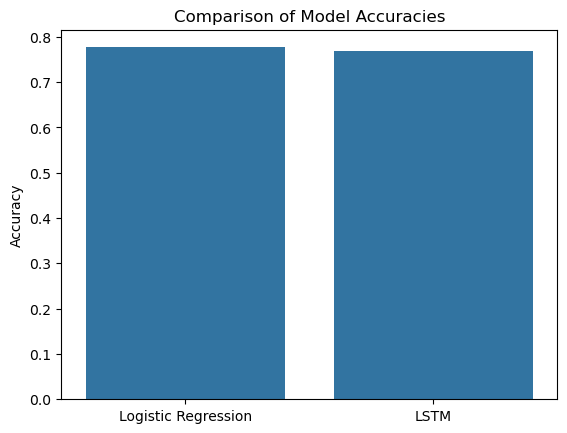

In [24]:
# Assuming df_report_lr and df_report_lstm are the DataFrames of your classification reports as shown above

import seaborn as sns

# Extracting the 'accuracy' row from each report
accuracy_data = {
    'Logistic Regression': df_report_lr.loc['accuracy', 'precision'],
    'LSTM': df_report_lstm.loc['accuracy', 'precision']
}

# Creating a bar chart
sns.barplot(x=list(accuracy_data.keys()), y=list(accuracy_data.values()))
plt.title('Comparison of Model Accuracies')
plt.ylabel('Accuracy')
plt.show()

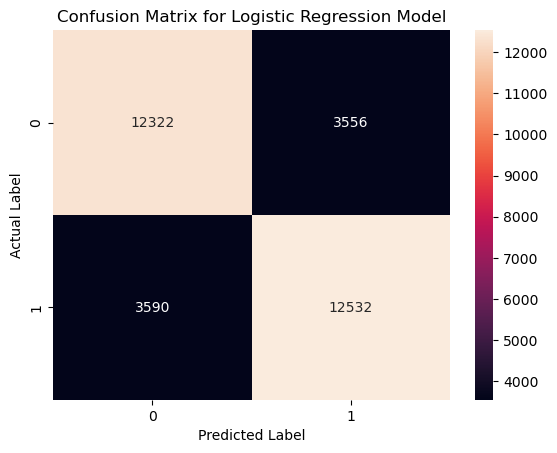

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions_lr)

# Plot using seaborn
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()